# ICU Mortality Risk

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
from sklearn.datasets import make_classification

# Load the available CSV file
csv_file_path = 'mimic_iv_data/mimic_iv_classification_regression_tasks.csv'
try:
    data_df = pd.read_csv(csv_file_path)
    print("\n--- Loaded Data (first 5 rows) ---")
    print(data_df.head())
except FileNotFoundError as e:
    print(f"Error: {e}")


--- Loaded Data (first 5 rows) ---
   subject_id   stay_id               intime              outtime  Age gender  \
0    10000032  39553978  2180-07-23 14:00:00  2180-07-23 23:50:47   52      F   
1    10000980  39765666  2189-06-27 08:42:00  2189-06-27 20:38:27   73      F   
2    10001217  37067082  2157-11-20 19:18:02  2157-11-21 22:08:00   55      F   
3    10001217  34592300  2157-12-19 15:42:24  2157-12-20 14:27:41   55      F   
4    10001725  31205490  2110-04-11 15:52:22  2110-04-12 23:59:56   46      F   

                ethnicity insurance  label                  dod   hadm_id  
0                   WHITE  Medicaid      0  2180-09-09 00:00:00  29079034  
1  BLACK/AFRICAN AMERICAN  Medicare      0  2193-08-26 00:00:00  26913865  
2                   WHITE     Other      0                    0  24597018  
3                   WHITE     Other      0                    0  27703517  
4                   WHITE     Other      0                    0  25563031  


In [4]:
# Data Cleaning and Feature Engineering
data_df['intime'] = pd.to_datetime(data_df['intime'], errors='coerce')
data_df['outtime'] = pd.to_datetime(data_df['outtime'], errors='coerce')
data_df['dod'] = pd.to_datetime(data_df['dod'], errors='coerce')

# Calculate length of stay
data_df['length_of_stay'] = (data_df['outtime'] - data_df['intime']).dt.total_seconds() / (60 * 60 * 24)
data_df['is_deceased'] = data_df['dod'].notna().astype(int)

# Define Categorical and Numerical Features
categorical_features = ['gender', 'ethnicity', 'insurance']
numerical_features = ['Age', 'length_of_stay']

# Preprocessing Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Splitting Features and Target
X = data_df.drop(columns=['subject_id', 'stay_id', 'intime', 'outtime', 'dod', 'label'])
y = data_df['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)


In [5]:
# Model Training and Evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, prefix=""):
    results = {}
    for model_name, model in models.items():
        print(f"\n--- Training {model_name} {prefix} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"\nAccuracy for {model_name} {prefix}: {accuracy:.4f}")
        print(f"AUC-ROC for {model_name} {prefix}: {roc_auc:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
        results[model_name] = {"model": model, "accuracy": accuracy, "roc_auc": roc_auc}
    return results

# Train and Evaluate Models on Original Data
model_results = train_and_evaluate_models(models, X_train_preprocessed, y_train, X_test_preprocessed, y_test)



--- Training Logistic Regression  ---

Accuracy for Logistic Regression : 0.9342
AUC-ROC for Logistic Regression : 0.6997

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     14379
           1       0.45      0.01      0.03      1010

    accuracy                           0.93     15389
   macro avg       0.69      0.51      0.50     15389
weighted avg       0.90      0.93      0.90     15389


Confusion Matrix:
 [[14362    17]
 [  996    14]]

--- Training Random Forest  ---

Accuracy for Random Forest : 0.9134
AUC-ROC for Random Forest : 0.6197

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     14379
           1       0.13      0.06      0.08      1010

    accuracy                           0.91     15389
   macro avg       0.54      0.52      0.52     15389
weighted avg       0.88      0.91      0.90     15389


Confusion Matrix

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy for XGBoost : 0.9339
AUC-ROC for XGBoost : 0.6936

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97     14379
           1       0.18      0.00      0.00      1010

    accuracy                           0.93     15389
   macro avg       0.56      0.50      0.48     15389
weighted avg       0.89      0.93      0.90     15389


Confusion Matrix:
 [[14370     9]
 [ 1008     2]]


In [6]:
# Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_xgb = grid_search.best_estimator_
print("\nBest Parameters for XGBoost:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}


 98%|===================| 15030/15389 [00:26<00:00]        

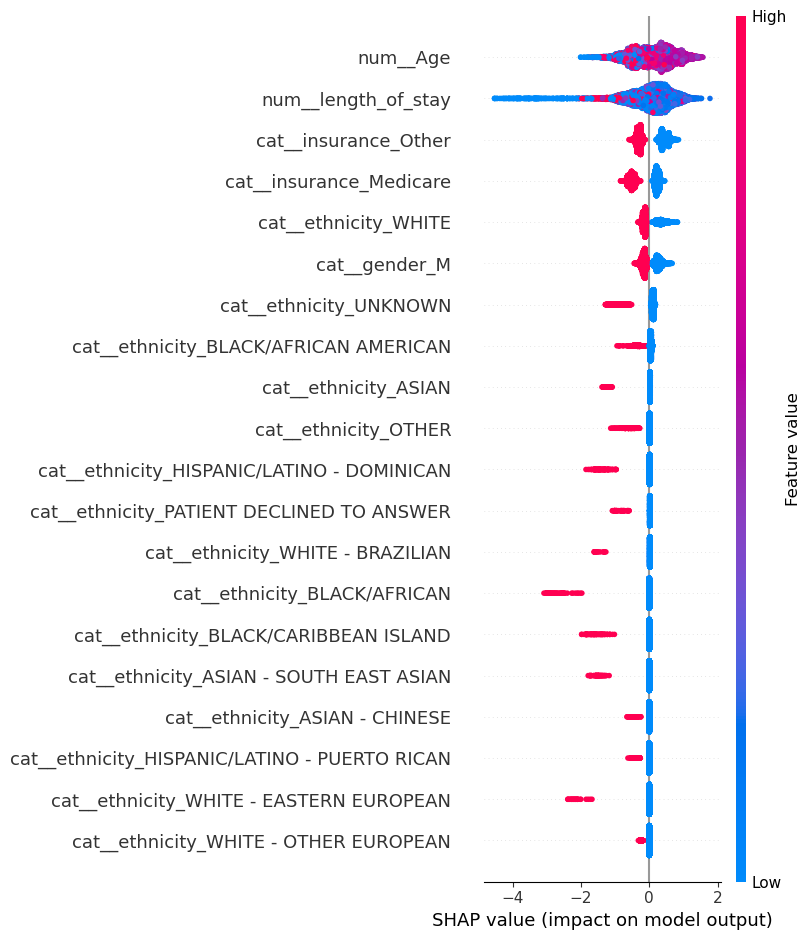

<Figure size 640x480 with 0 Axes>

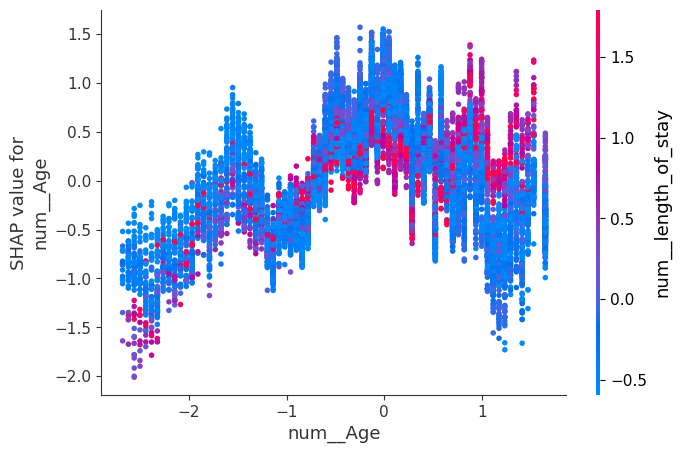

In [7]:
# SHAP Interpretation for XGBoost
shap.initjs()
X_test_dense = X_test_preprocessed.toarray() if hasattr(X_test_preprocessed, "toarray") else X_test_preprocessed
explainer = shap.Explainer(best_xgb, X_test_dense)
shap_values = explainer(X_test_dense)

# SHAP Summary Plot
plt.figure()
shap.summary_plot(shap_values.values, X_test_dense, feature_names=preprocessor.get_feature_names_out())

# SHAP Dependence Plot
age_feature_name = [name for name in preprocessor.get_feature_names_out() if 'Age' in name][0]
plt.figure()
shap.dependence_plot(age_feature_name, shap_values.values, X_test_dense, feature_names=preprocessor.get_feature_names_out())

In [9]:
# New Data

# Define the number of synthetic samples
n_samples = 10

# Generate a more varied synthetic dataset
n_numerical = len(['Age', 'length_of_stay'])
X_synthetic_numerical, _ = make_classification(
    n_samples=n_samples,
    n_features=n_numerical,
    n_informative=n_numerical,
    n_redundant=0,
    random_state=42,
    shift=[50, 7],  # Shifting the mean of 'Age' to a realistic average age and 'length_of_stay' to 7 days
    scale=[15, 3]   # Adding variability in 'Age' and 'length_of_stay'
)

# Ensure numerical features are within reasonable bounds
X_synthetic_numerical = np.clip(X_synthetic_numerical, [18, 0.5], [91, 30])  # Age between 18 and 91, LOS between 0.5 and 30 days

# Generate synthetic categorical features
np.random.seed(42)
gender_options = ['M', 'F']
ethnicity_options = [
    'WHITE', 'BLACK/AFRICAN AMERICAN', 'ASIAN - CHINESE', 'HISPANIC OR LATINO', 'OTHER'
]
insurance_options = ['Medicare', 'Medicaid', 'Private', 'Other']

gender_synthetic = np.random.choice(gender_options, size=n_samples)
ethnicity_synthetic = np.random.choice(ethnicity_options, size=n_samples)
insurance_synthetic = np.random.choice(insurance_options, size=n_samples)

# Combine numerical and categorical features
synthetic_data = {
    'Age': X_synthetic_numerical[:, 0],
    'length_of_stay': X_synthetic_numerical[:, 1],
    'gender': gender_synthetic,
    'ethnicity': ethnicity_synthetic,
    'insurance': insurance_synthetic
}

# Create a DataFrame for the synthetic data
synthetic_data_df = pd.DataFrame(synthetic_data)

# Display the synthetic data to verify its diversity
print("\n--- New Synthetic Data (first 5 rows) ---")
print(synthetic_data_df.head())

# Step 2: Preprocess the New Data
# Assuming you have a preprocessor object from earlier
X_synthetic_preprocessed = preprocessor.transform(synthetic_data_df)

# Step 3: Predict the mortality risk for synthetic data using the trained XGBoost model
predicted_probabilities = best_xgb.predict_proba(X_synthetic_preprocessed)[:, 1]

# Define a threshold for classifying based on predicted probabilities
selected_threshold = 0.5  # You can adjust this threshold based on the project's requirements

# Classify based on the selected threshold
predicted_classes = (predicted_probabilities >= selected_threshold).astype(int)

# Display the predictions
print("\n--- Predicted Mortality Risk for New Synthetic Data ---")
print(predicted_classes)

# Optionally, display the predicted probabilities as well
print("\n--- Predicted Mortality Risk Probabilities for New Synthetic Data ---")
print(predicted_probabilities)


--- New Synthetic Data (first 5 rows) ---
         Age  length_of_stay gender           ethnicity insurance
0  24.205017            30.0      M     ASIAN - CHINESE     Other
1  18.000000            30.0      F     ASIAN - CHINESE     Other
2  18.000000            30.0      M     ASIAN - CHINESE  Medicare
3  18.838097            30.0      M               OTHER  Medicare
4  18.000000            30.0      M  HISPANIC OR LATINO     Other

--- Predicted Mortality Risk for New Synthetic Data ---
[0 0 0 0 0 0 0 1 0 0]

--- Predicted Mortality Risk Probabilities for New Synthetic Data ---
[0.19919878 0.06491542 0.21213286 0.03434963 0.12656136 0.04006183
 0.0301909  0.6604589  0.10452123 0.22592306]
